### Project Summary

In this project, I will be using python to explore and analyse an industry retail dataset provided by AiCore. The project has three main sections:

1. **Downloading the dataset from AWS RDS**. This part is not including in this notebook. It is executed directly on the `db_utils.py` file contained in the project's repository. The table is downloaded as a .csv and stored locally. This is then uploaded as a dataframe using pandas `pd.read_csv` built-in function.

2. **Data exploration, cleaning and pre-processing.** The data will be investigated to find inaccuracies, trends and outliers. The data will be then cleaned using custom-built functions (`transformer.py`) and prepared for further ML processing. This notebook focuses solely on this part.

3. **Extracting business insights: data analysis and visualisation.** I will answer business questions by creating custom data visualisations, using pandas, matplotlib and seaborn libraries. This analysis can be found in a separate Jupyter notebook called `analysis_report.ipynb`.

# Data Exploration, Cleaning and ML Pre-Processing

In [1]:
# Import statements
from scipy.stats import chi2_contingency, normaltest
from scipy import stats
from scripts.info_extractor import DataFrameInfo
from scripts.transformer import DataTransform
from scripts.outlier_detector import OutlierDetector
from scripts.statistical_tests import StatisticalTests
from scripts.plotter import Plotter
from statsmodels.graphics.gofplots import qqplot

import missingno as msno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

## **Initial Data Exploration**

First we will load the data and perform the initial exploratory analysis.

In [2]:
# Loading the data
customer_activity_df = pd.read_csv('data/customer_activity.csv')
print(f"The shape of the DataFrame is: {customer_activity_df.shape}")
customer_activity_df.head()

The shape of the DataFrame is: (12330, 17)


,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values,month,operating_systems,browser,region,traffic_type,visitor_type,weekend,revenue
0,0.0,0.0,0,0.0,4.0,0.0,0.2000,0.200,0.0,May,Android,Google Chrome,North America,Twitter,Returning_Visitor,False,False
1,0.0,0.0,0,0.0,26.0,876.0,0.0000,0.026,0.0,Nov,Windows,Google Chrome,Western Europe,Google search,Returning_Visitor,True,False
2,2.0,99.4,0,0.0,19.0,368.0,0.0396,0.052,0.0,Sep,Windows,Google Chrome,Asia,Twitter,Returning_Visitor,False,False
3,0.0,0.0,0,0.0,20.0,1432.0,0.0248,0.028,1.8,Dec,Windows,Google Chrome,Western Europe,Instagram ads,Returning_Visitor,False,True
4,0.0,0.0,0,0.0,33.0,694.0,0.0141,0.032,0.0,May,Android,Google Chrome,North America,Instagram ads,Returning_Visitor,False,False


In [3]:
# First look at distribution of data in numeric columns
customer_activity_df.describe()

,administrative,administrative_duration,informational,informational_duration,product_related,product_related_duration,bounce_rates,exit_rates,page_values
count,11760.000000,11418.000000,12330.000000,11994.000000,11751.000000,12129.000000,12330.000000,12330.000000,12330.000000
mean,2.308844,84.539079,0.497080,34.486687,32.814824,1192.426086,0.022381,0.042820,5.556310
std,3.364905,179.392485,1.174194,136.201557,44.597841,1767.243802,0.048847,0.048578,17.397345
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,192.000000,0.000000,0.014000,0.000000
50%,1.000000,6.000000,0.000000,0.000000,18.000000,586.000000,0.003500,0.025000,0.000000
75%,4.000000,95.000000,0.000000,0.000000,38.000000,1425.000000,0.017600,0.049000,0.000000
max,24.000000,2155.000000,12.000000,1988.750000,485.000000,23866.000000,0.200000,0.200000,254.600000


In [4]:
# First we create an instance of the DataFrameInfo class:
info_extractor = DataFrameInfo(customer_activity_df)

# How many distint values are there per column?
print('\n', info_extractor.count_distinct_values())


                           distinct_values_count
column                                         
administrative                               24
administrative_duration                    3357
informational                                13
informational_duration                     1280
product_related                             296
product_related_duration                   3494
bounce_rates                                613
exit_rates                                  164
page_values                                 742
month                                        10
operating_systems                             7
browser                                      13
region                                        9
traffic_type                                 19
visitor_type                                  3
weekend                                       2
revenue                                       2


In [5]:
# What are all the different categories in categorical columns?
info_extractor.show_distinct_values(['administrative','browser','operating_systems'])

Unique values in administrative: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 23. 24. nan]
Unique values in browser: ['Android' 'Google Chrome' 'Internet Explorer' 'Microsoft Edge'
 'Mozilla Firefox' 'Opera' 'QQ' 'Safari' 'Samsung Internet'
 'Sogou Explorer' 'UC Browser' 'Undetermined' 'Yandex']
Unique values in operating_systems: ['Android' 'Windows' 'MACOS' 'ChromeOS' 'iOS' 'Ubuntu' nan 'Other']


In [6]:
# Example: value counts for a specific category
print("\nThe different vistor types in the dataset, and the number of records for each are: ")
print(customer_activity_df['visitor_type'].value_counts())


The different vistor types in the dataset, and the number of records for each are: 
visitor_type
Returning_Visitor    10691
New_Visitor           1570
Other                   69
Name: count, dtype: int64


In [7]:
# Checking number of non-null values and column data types
print(customer_activity_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   administrative            11760 non-null  float64
 1   administrative_duration   11418 non-null  float64
 2   informational             12330 non-null  int64  
 3   informational_duration    11994 non-null  float64
 4   product_related           11751 non-null  float64
 5   product_related_duration  12129 non-null  float64
 6   bounce_rates              12330 non-null  float64
 7   exit_rates                12330 non-null  float64
 8   page_values               12330 non-null  float64
 9   month                     12330 non-null  object 
 10  operating_systems         12319 non-null  object 
 11  browser                   12330 non-null  object 
 12  region                    12330 non-null  object 
 13  traffic_type              12330 non-null  object 
 14  visito

#### **First look at the data: What have we learned?**

- 17 columns and 12330 records (rows).

- **Administrative/Informational/Product_related columns**: indicate which task has been performed. They are already encoded by an integer. There are 24 distinct adminitrative tasks, 13 distinct informational tasks and 296 distinct product-related tasks. For example, an administrative task can be logging into the website, whereas a product_related task could be adding a specific product to the basker.

- **Task duration columns**: indicate the time spent on each task. When a task has not been performed, the duration is set to zero. This will inevitably skew the data towards zero. We will chekc this in the next sections.

- **Columns with data type 'Object'**: will have to change to a more suitable data type in the next section.

- **Null values**: there are null values in some columns of the dataset. Further exploration is needed.

##### How many **null values** are there in our dataset? In which columns?

In [8]:
# Call custom-made function generate null counts and percentages for each columns.
print(info_extractor.generate_null_counts())

                          null_count  null_percentage
administrative                   570         4.622871
administrative_duration          912         7.396594
informational                      0         0.000000
informational_duration           336         2.725061
product_related                  579         4.695864
product_related_duration         201         1.630170
bounce_rates                       0         0.000000
exit_rates                         0         0.000000
page_values                        0         0.000000
month                              0         0.000000
operating_systems                 11         0.089213
browser                            0         0.000000
region                             0         0.000000
traffic_type                       0         0.000000
visitor_type                       0         0.000000
weekend                            0         0.000000
revenue                            0         0.000000


<Axes: >

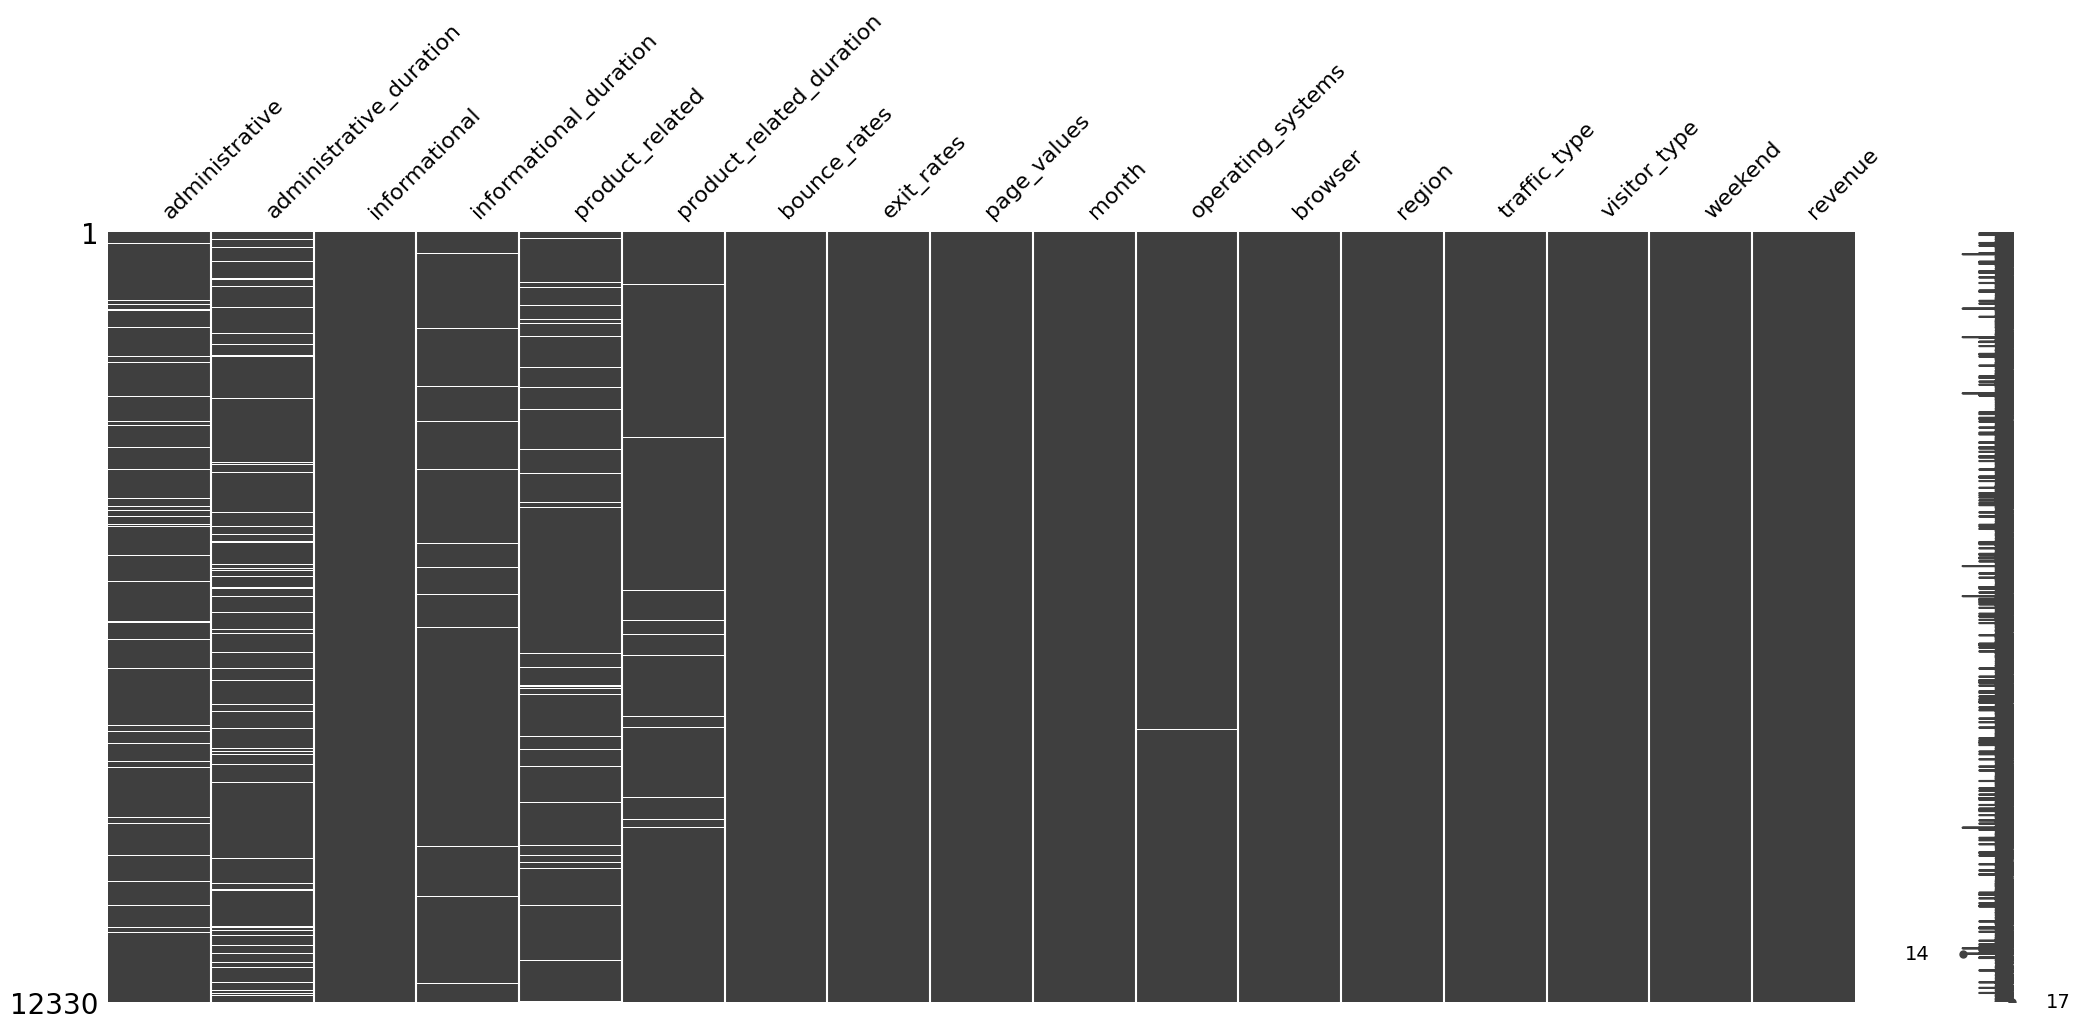

In [9]:
# Visualise missing values with the missingno library.
nulls_plot = msno.matrix(customer_activity_df)
nulls_plot

#### **First look at null values: What have we learned?**

- Column with most null values: **7.4 %** of nulls are in the `administrative_duration` column.

- Most other null values are in the following columns (descending order): `product_related`, `administrative`, `informational_duration`, `product_related_duration`.

- The column with the lowest number of nulls is `operating_systems` with only 11 missing values (0.09 %).


## **Data Cleaning**

#### In this section, we will convert some columns to different data types and impute all missing values in the dataset.

#### When deciding how to impute missing values, we will first assess missingness type using various mathematical approaches.

### **Converting columns to specific data types**

The column data type transformations are as follows:

|       Column      | current dtype | to dtype |                       Reason                       |
|:-----------------:|:-------------:|:--------:|:--------------------------------------------------:|
|   administrative  |    float64    |   int64  |     Discrete data: each integer encodes a task.    |
|  product_related  |    float64    |   int64  |     Discrete data: each integer encodes a task.    |
|       month       |     object    | datetime or period[M]| To access to time-intelligent functions in python. |
|      browser      |     object    | category |                  Categorical data.                 |
|       region      |     object    | category |                  Categorical data.                 |
|    traffic_type   |     object    | category |                  Categorical data.                 |
| operating_systems |     object    | category |                  Categorical data.                 |
|    visitor_type   |     object    | category |                  Categorical data.                 |
|      weekend      |      bool     |   int64  |  Helps data analysis and allows ML model training. |
|      revenue      |      bool     |   int64  |  Helps data analysis and allows ML model training. |

The only transformations that **cannot** be done now are:

1. Coverting `administrative` and `product_related`: as long as there are nulls, data type is float64. Need to convert these **after imputing null values**.

In [10]:
# Create instance of transformer class
transformer = DataTransform(customer_activity_df)

In [11]:
formatted_df = transformer.convert_columns(['weekend','revenue'],'int')
formatted_df = transformer.convert_columns(['browser','region','traffic_type','operating_systems','visitor_type'],'categorical')
formatted_df = transformer.convert_month_to_period('month')
# Also available: function 'convert_month_to_datetime' to convert to datetime datatype. For our purpose, we will convert to period in this notebook.
formatted_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype    
---  ------                    --------------  -----    
 0   administrative            11760 non-null  float64  
 1   administrative_duration   11418 non-null  float64  
 2   informational             12330 non-null  int64    
 3   informational_duration    11994 non-null  float64  
 4   product_related           11751 non-null  float64  
 5   product_related_duration  12129 non-null  float64  
 6   bounce_rates              12330 non-null  float64  
 7   exit_rates                12330 non-null  float64  
 8   page_values               12330 non-null  float64  
 9   month                     12330 non-null  period[M]
 10  operating_systems         12319 non-null  category 
 11  browser                   12330 non-null  category 
 12  region                    12330 non-null  category 
 13  traffic_type              12330

### **Assessing missigness type and imputing null values**

#### Theory on Missingness Mechanisms

What causes the data to be missing is known as the Missingness Mechanism. There are three main types:

1. **Missing Completely at Random (MCAR).** Missingness presenting in your data is in a totally random pattern.
    - *How do we diagnose it?* Different ways. Little's test can be used for this purpose.
    - Does not introduce bias.
    - Some more information and references can be found here: [What to do with missing data?](https://www.lancaster.ac.uk/stor-i-student-sites/tessa-wilkie/2020/05/01/missing-data-part-ii-what-to-do-with-missing-data/)

1. **Missing at Random (MAR).** The probability of an observation missing depends on other observed variables but not the variable itself. If the cause of the missingness depends on some observed variable or variables that have been collected, the missing data mechanism is assumed to be MAR. Imagine a university does a survey of previous students, to find out where they are working, what their income bracket is, etc. Let’s say that alumni that work in a particular sector are less likely to disclose their income. But, they do disclose what sector it is that they work in. 
    - Introduces some bias.

**MCAR vs MAR**

| Diagnosing Missigness Mechanism |           When to use          |                           Disadvantages                          | Output                                                                                          |
|:-------------------------------:|:------------------------------:|:----------------------------------------------------------------:|-------------------------------------------------------------------------------------------------|
|        Little's MCAR Test       | Assumes multivariate normality | Does not identify which variables are associated with missigness | if p > significance level: no evidence to reject H0: data are MCAR. If p<sig. level: Reject H0. |

3. **Missing Not at Random (MNAR).** The probability of an observation missing depends on the values of the missing data itself, even after controlling for other observed variables. If the missing data mechanism is MNAR, the cause of the missingness cannot be controlled for. E.g. people with higher incomes are less likely to disclose their income in a survey. 
There are two reasons the missing data mechanism may be MNAR:
- **The researcher doesn’t know why the data are missing.** For example, in a longitudinal study, after a certain age, data is no longer collected, but the researcher neglected to ask the participants their age.
- **The data are missing because of the dependent variable.** For example, in a study of severe asthma where the measurements are taken at school, students who have severe asthma are absent more frequently because of their asthma. Hence the reason the data are missing is because students with severe asthma aren’t being measured when they don’t come to school. On the previous MAR example: what if students are less likely to respond to that income question the more they earn? Then we have Missing Not at Random data. The missingness depends on something we do not observe.
    - Introduces significant bias.
    - *How do we deal with it?* Complex statistical techniques are needed to impute missing values. This is very difficult to deal with and often causes bias in our analysis. To make it even more difficult, we cannot test whether the missingness mechanism is Missing at Random or Missing Not at Random.
    - *How do we diagnose it?* The first thing in diagnosing randomness of the missing data is to use your substantive scientific knowledge of the data and your field. The more sensitive the issue, the less likely people are to tell you. 

Checkout this resource for theory on Missigness Mechanisms and useful references: [Missing Data: Introducing the Missingness Mechanism](https://www.lancaster.ac.uk/stor-i-student-sites/tessa-wilkie/2020/04/29/missing-data-part-1-introducing-the-missingness-mechanism/)


| Simple methods to deal with missing data |                                      When to use                                     |                              Disadvantages                             |
|:--------------------------------------:|:------------------------------------------------------------------------------------:|:----------------------------------------------------------------------:|
|    Listwise Deletion (dropping rows)   |                              MCAR, nulls are < 1% of the data                              |          Might lose statistical power or important information         |
|          Drop entire variable          |    Number of missing values for a variable is very high and variable not essential   |                            Drastic approach                            |
|          Imputation with mean          |                         MCAR, continuous data, normally distributed                        |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias |
|         Imputation with median         |                                MCAR, continuous data, skewed                               |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias  |
|          Imputation with mode          |                                   MCAR, categorical data                                   |  Increases the variance of the imputed variable / Does not reflect uncertainty / May add bias  |
|        Constant value imputation       |                If there is a logical value for missing data e.g. zero                | Can severely distort the distribution of your data if used incorrectly |
|          Regression imputation         | The column with missing data is highly correlated to one/more columns in the dataset |                          Biased under MCAR                         |


Other methods to deal with missing data are: Stochastic imputation, K-Nearest Neighbours(KNN) Imputation, Multiple Imputation by Chain Equations (MICE), and deep learning.
Relevant links:

[A Guide on Data Analysis: Imputation (Missing data)](https://bookdown.org/mike/data_analysis/assumptions-1.html)

[Choosing a Missing Data Technique](https://www.youtube.com/watch?v=9Uxr3Y-zJIY)


#### **Missigness in our dataset**


|        Column Name       | % nulls | Data type and distribution | Missingness Type | Method to deal with missing data |
|:------------------------:|:-------:|:--------------------------:|:----------------:|:--------------------------------:|
|      administrative      |   4.6   |     Categorical, skewed    |       MCAR         |              Impute with mode                    |
|  administrative_duration |   7.4   |     Continuous, skewed     |         MCAR         |            Impute with median                      |
|  informational_duration  |   2.7   |     Continuous, skewed     |         MCAR         |                 Impute with median                 |
|      product_related     |   4.7   |     Categorical, skewed    |         MCAR         |          Impute with mode                        |
| product_related_duration |   1.6   |     Continuous, skewed     |         MCAR         |           Impute with median                       |
|     operating_systems    |   0.09  |         Categorical        |    Irrelevant    |         Listwise Deletion        |



#### Listwise Deletion: Null values in `operating_systems` column

In [12]:
# First drop rows for missing values in the operating_systems column, they constitute < 1 % of values
cleaned_df = formatted_df.dropna(subset=["operating_systems"])

#### *Optional: dropping rows where `operating_systems` = 'Undetermined' and `visitor_type` = 'Other'*

In [13]:
# NOTE You could have left these in if you liked as it could be useful data but totally fair assessment to drop it as well. Just something to point out. 
# Would really depend on what question was needing answered. 
#cleaned_df = cleaned_df[(cleaned_df['browser'] != 'Undetermined') & (cleaned_df['visitor_type'] != 'Other')]
#info_extractor = DataFrameInfo(cleaned_df)
#info_extractor.count_distinct_values()

#### Create instances of each utility class

In [14]:
info_extractor = DataFrameInfo(cleaned_df)
transformer = DataTransform(cleaned_df)
stats_tests = StatisticalTests(cleaned_df)
plotter = Plotter(cleaned_df)

#### Missing values in `administrative` column

Categorical variable: numbers encode different administrative tasks.
Therefore, as long as it is MCAR, we should impute with the mode. 

/Users/silviaaragon/Aicore/EDA-Project-Code-Review/Exploratory-data-analysis---Online-shopping-in-retail/scripts/plotter.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  dpd.set_xticklabels(dpd.get_xticklabels(), rotation=45, ha='right')


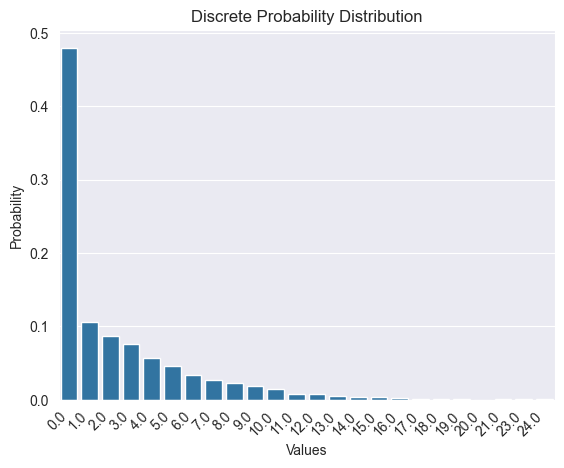

In [15]:
plotter.discrete_probability_distribution('administrative')

In [16]:
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]
categorical_features = info_extractor.extract_categorical_features(numeric_features)
print(type(categorical_features))

<class 'list'>


In [17]:
for column in categorical_features:
    stats_tests.chi_square_test('administrative', [column])

Chi-square test for missing values in administrative against administrative column: 
p-value = 0.0
Chi-square test for missing values in administrative against informational column: 
p-value = 0.8184044352785724
Chi-square test for missing values in administrative against product_related column: 
p-value = 0.6211676822340683
Chi-square test for missing values in administrative against month column: 
p-value = 0.7505773361371723
Chi-square test for missing values in administrative against operating_systems column: 
p-value = 0.8507826337893809
Chi-square test for missing values in administrative against browser column: 
p-value = 0.662427354955117
Chi-square test for missing values in administrative against region column: 
p-value = 0.6320241226662666
Chi-square test for missing values in administrative against traffic_type column: 
p-value = 0.9469265793496497
Chi-square test for missing values in administrative against visitor_type column: 
p-value = 0.2720827457991167
Chi-square test

In [18]:
cleaned_df = transformer.impute_nulls_with_mode(["administrative"])

#### Missing values in `product_related` column

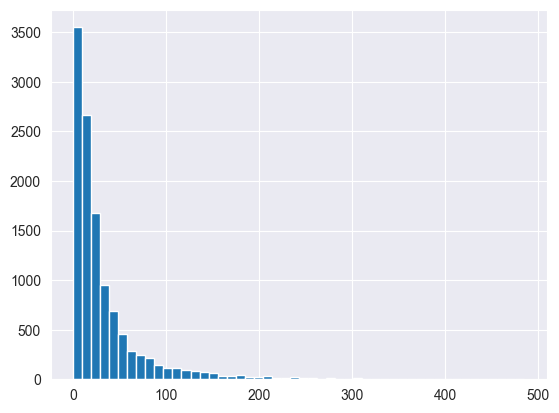

In [19]:
cleaned_df['product_related'].hist(bins = 50)
cleaned_df = transformer.impute_nulls_with_mode(["product_related"])

#### Missing values in `administrative_duration` column

Continuous variable. Potentially MCAR, or MAR if values missing depend on the missingness of values in the column 'administrative'. Let's check the correlation of both variables first, then we can perform a chi-square test

The mode of the distribution is 0.0
The mean of the distribution is 84.56652612801525
The median of the distribution is 6.0


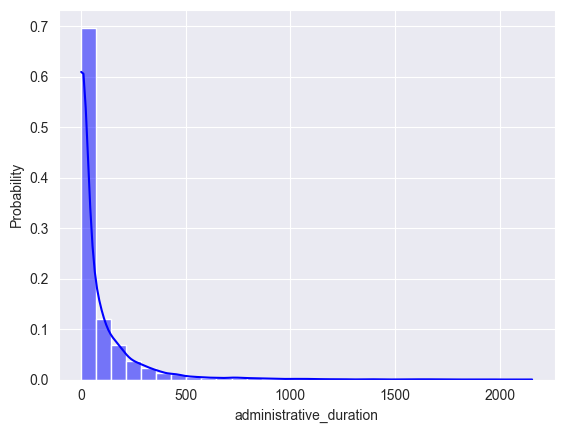

In [20]:
plotter.continuous_probability_distribution('administrative_duration')

In [21]:
cleaned_df = transformer.impute_nulls_with_median(["administrative_duration"])

#### Missing values in `informational_duration` column

The mode of the distribution is 0.0
The mean of the distribution is 34.4710697128699
The median of the distribution is 0.0


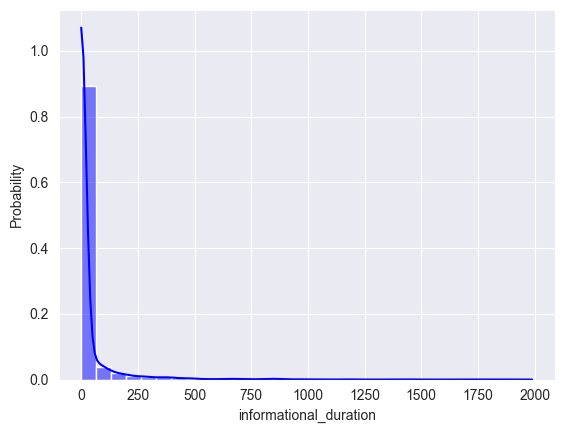

In [22]:
plotter.continuous_probability_distribution('informational_duration')

In [23]:
transformed_df = transformer.impute_nulls_with_median(['informational_duration'])

#### Missing values in `product_related_duration` column

The mode of the distribution is 0.0
The mean of the distribution is 1192.547202508665
The median of the distribution is 586.0


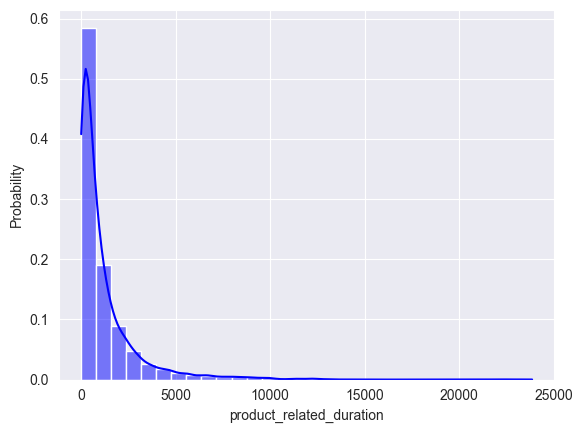

In [24]:
plotter.continuous_probability_distribution('product_related_duration')

In [25]:
cleaned_df = transformer.impute_nulls_with_median(['product_related_duration'])

### **Show clean and imputed data**
Now we can check if all nulls have been dropped or imputed:

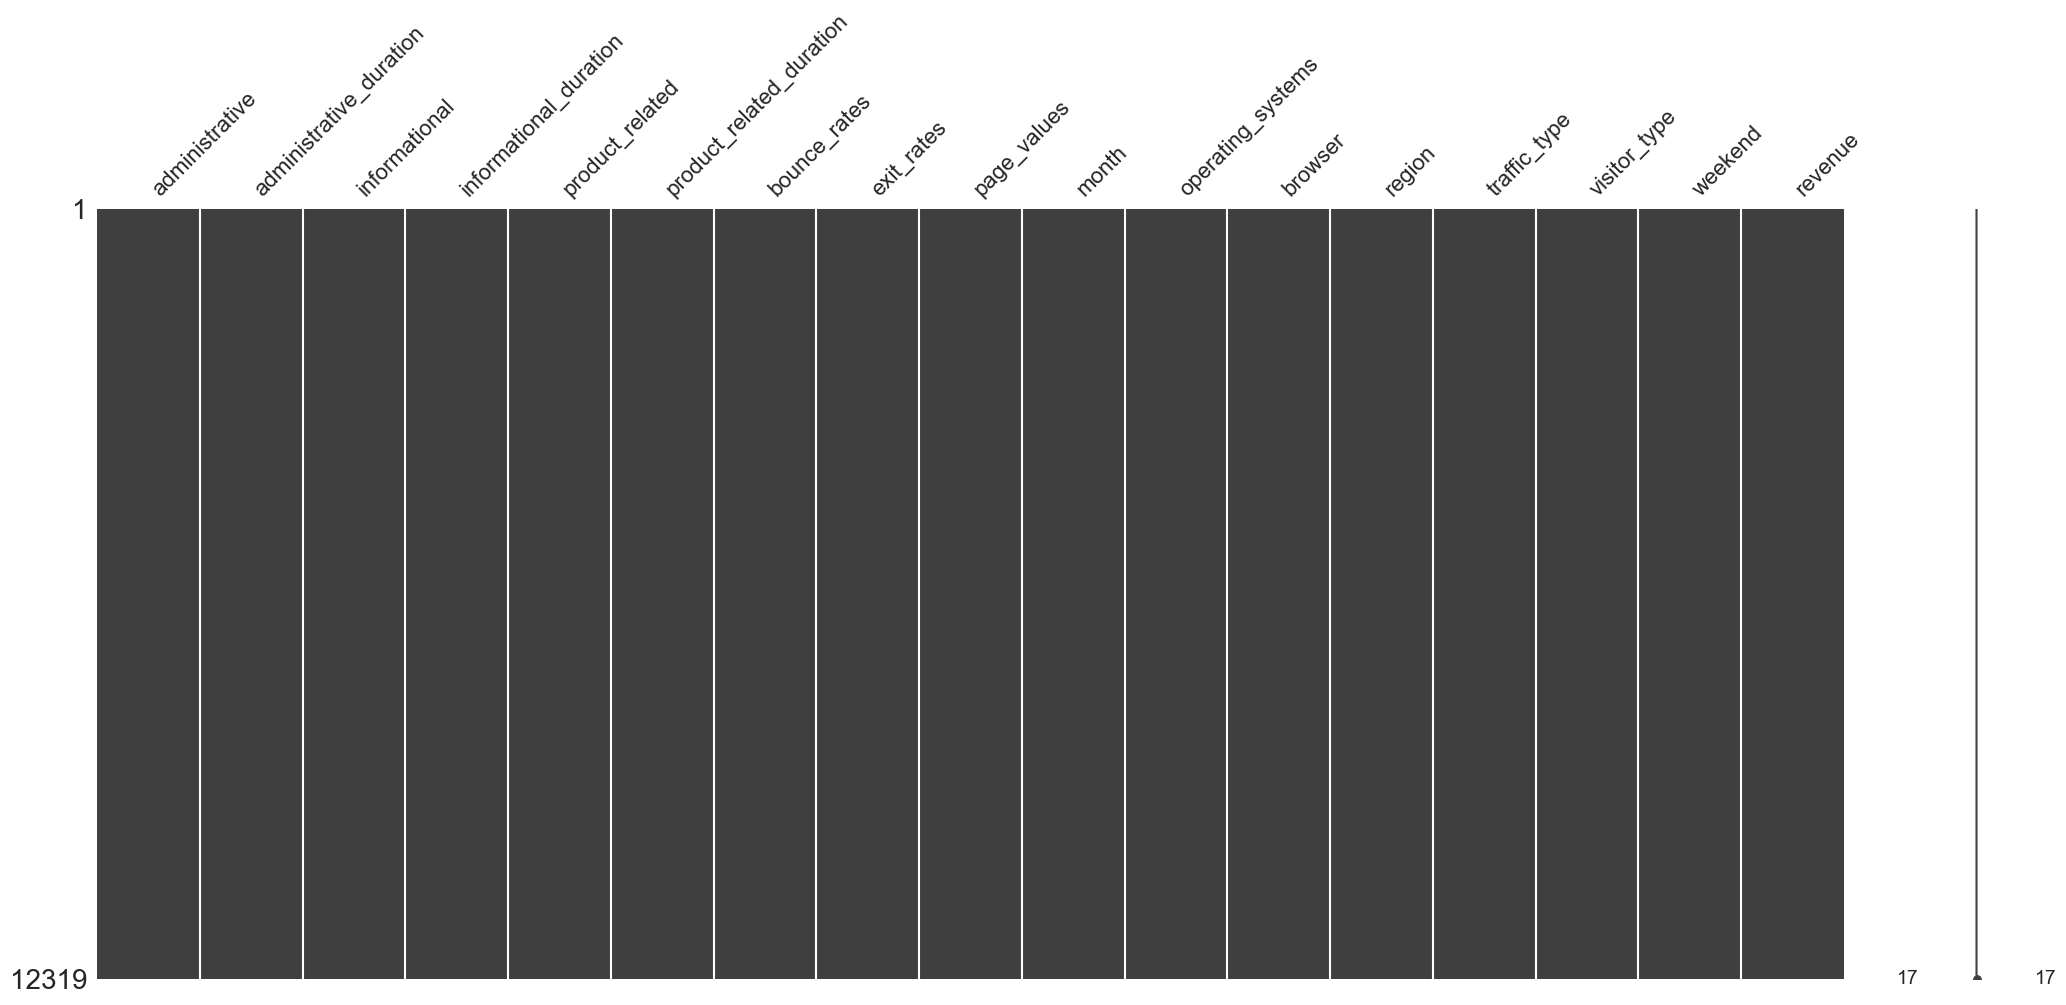

In [26]:
plotter = Plotter(cleaned_df)
plotter.nulls_dataframe_plot()

## **Data Cleaning: Pre-Processing for Machine Learning Applications**

### **Checking the distributions and skew of continuous numerical data**

+--------------------------+--------------------+
|          Column          |      Skewness      |
+--------------------------+--------------------+
| administrative_duration  | 4.666026221097623  |
|  informational_duration  | 7.208093359346399  |
| product_related_duration | 3.643882703043871  |
|       bounce_rates       | 2.949403110230985  |
|        exit_rates        | 2.1942737144627427 |
|       page_values        | 6.031533393301411  |
+--------------------------+--------------------+


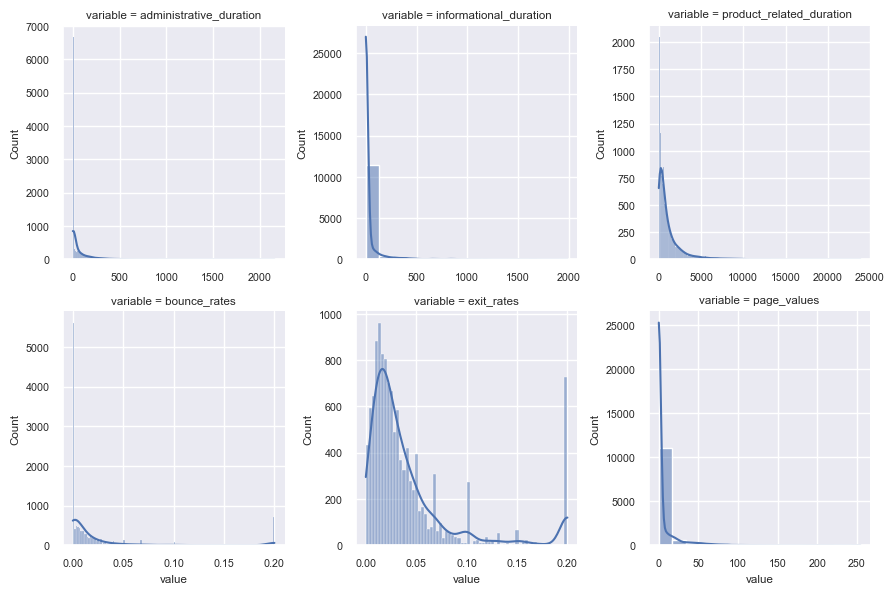

In [27]:
# NOTE Nice annotations on the graphs
numeric_features = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    ]

plotter.numeric_distributions_grid(numeric_features)
info_extractor.data_skewness_values(numeric_features)

### **Data Skewness: Q-Q plots**
All numerical data has high positive skew meaning that the values are greatly over represented by outliers. Also the mean and median are much higher than the mode. 

- Variables `administrative_duration`, `informational_duration` and `product_related_duration` are highly skewed towards zero, as zero is the value given when a specific task has not been performed. Some of the transformations below will not take into account the presence of zero values when transforming and calculating the skewness.

- Variable `bounce_rates` is also skewed towards zero as some website users will have stayed on the website instead of bouncing baack.

- Variable `exit_rates` has a high peak at 0.20. This could be because the website does not measure exit rates higher than that value, and users that stay for long periods of time on the website are under the maximum measurable value.

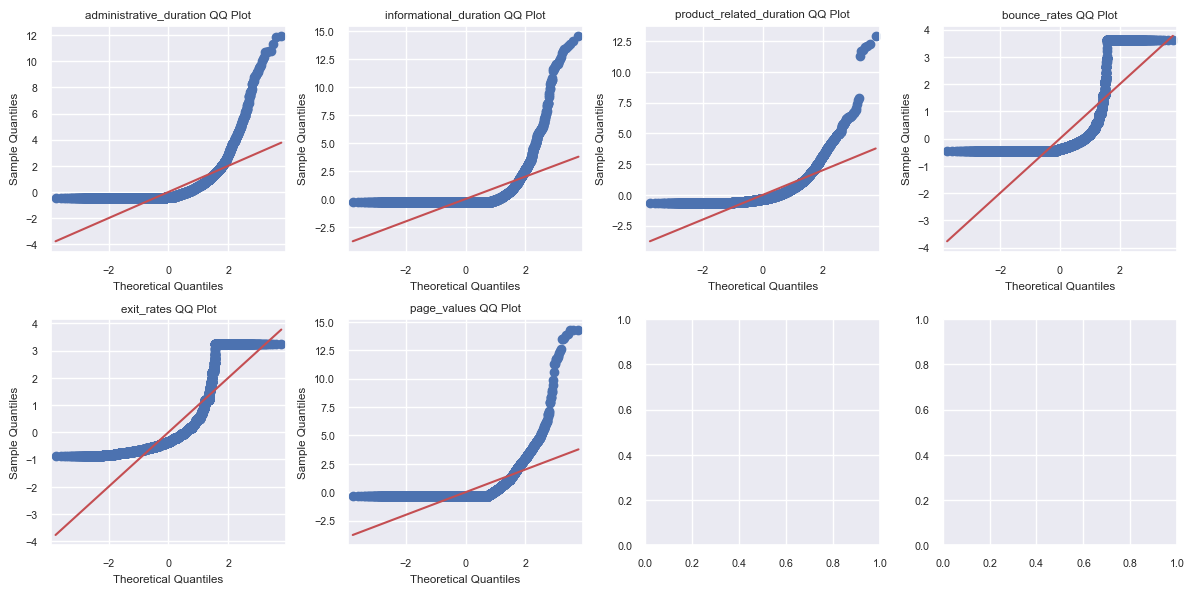

In [28]:
plotter.multi_qq_plot(numeric_features)

### **Correcting skew in numerical columns**


In [49]:
transformer = DataTransform(cleaned_df)
ML_transformed_df = transformer.log_transform(['bounce_rates','exit_rates','administrative_duration','informational_duration'])
ML_transformed_df = transformer.yeo_johnson_transform(['product_related_duration','page_values'])

+--------------------------+----------------------+
|          Column          |       Skewness       |
+--------------------------+----------------------+
| administrative_duration  | 0.33942923903904537  |
|  informational_duration  |  1.9073245666767467  |
| product_related_duration | -0.6594126719704976  |
|       bounce_rates       | -0.27337844121799487 |
|        exit_rates        | 0.12578915345240188  |
|       page_values        |  1.8245208888545068  |
+--------------------------+----------------------+


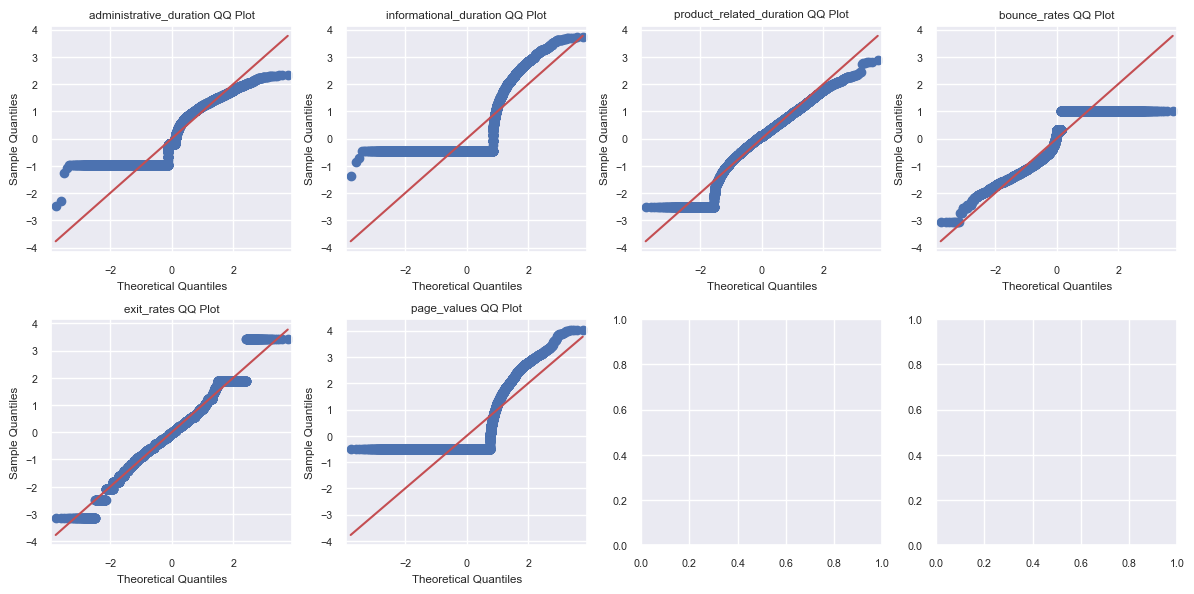

In [50]:
plotter = Plotter(ML_transformed_df)
info_extractor = DataFrameInfo(ML_transformed_df)
plotter.multi_qq_plot(numeric_features)
info_extractor.data_skewness_values(numeric_features)

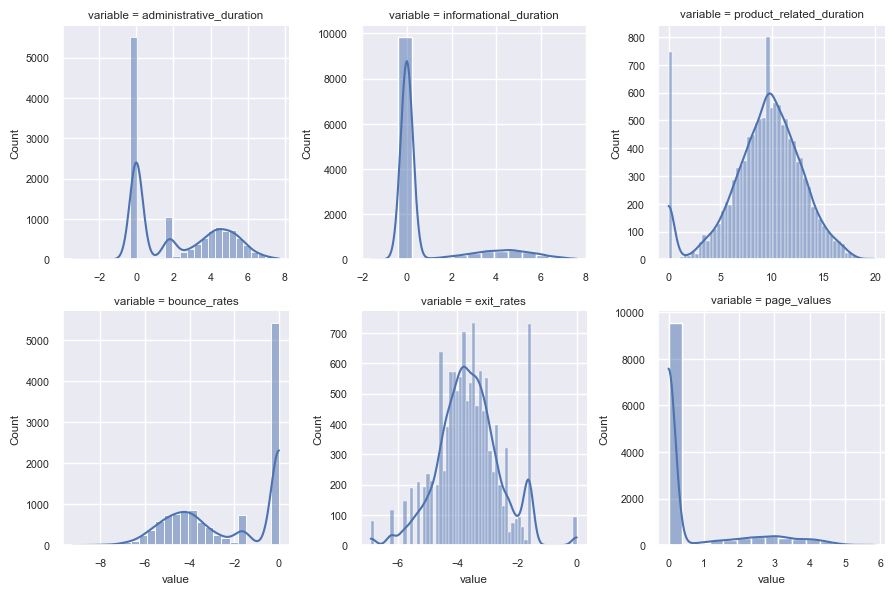

In [51]:
plotter.numeric_distributions_grid(numeric_features)

### **Dropping overly correlated columns: Measure correlation to understand which columns are redundant**

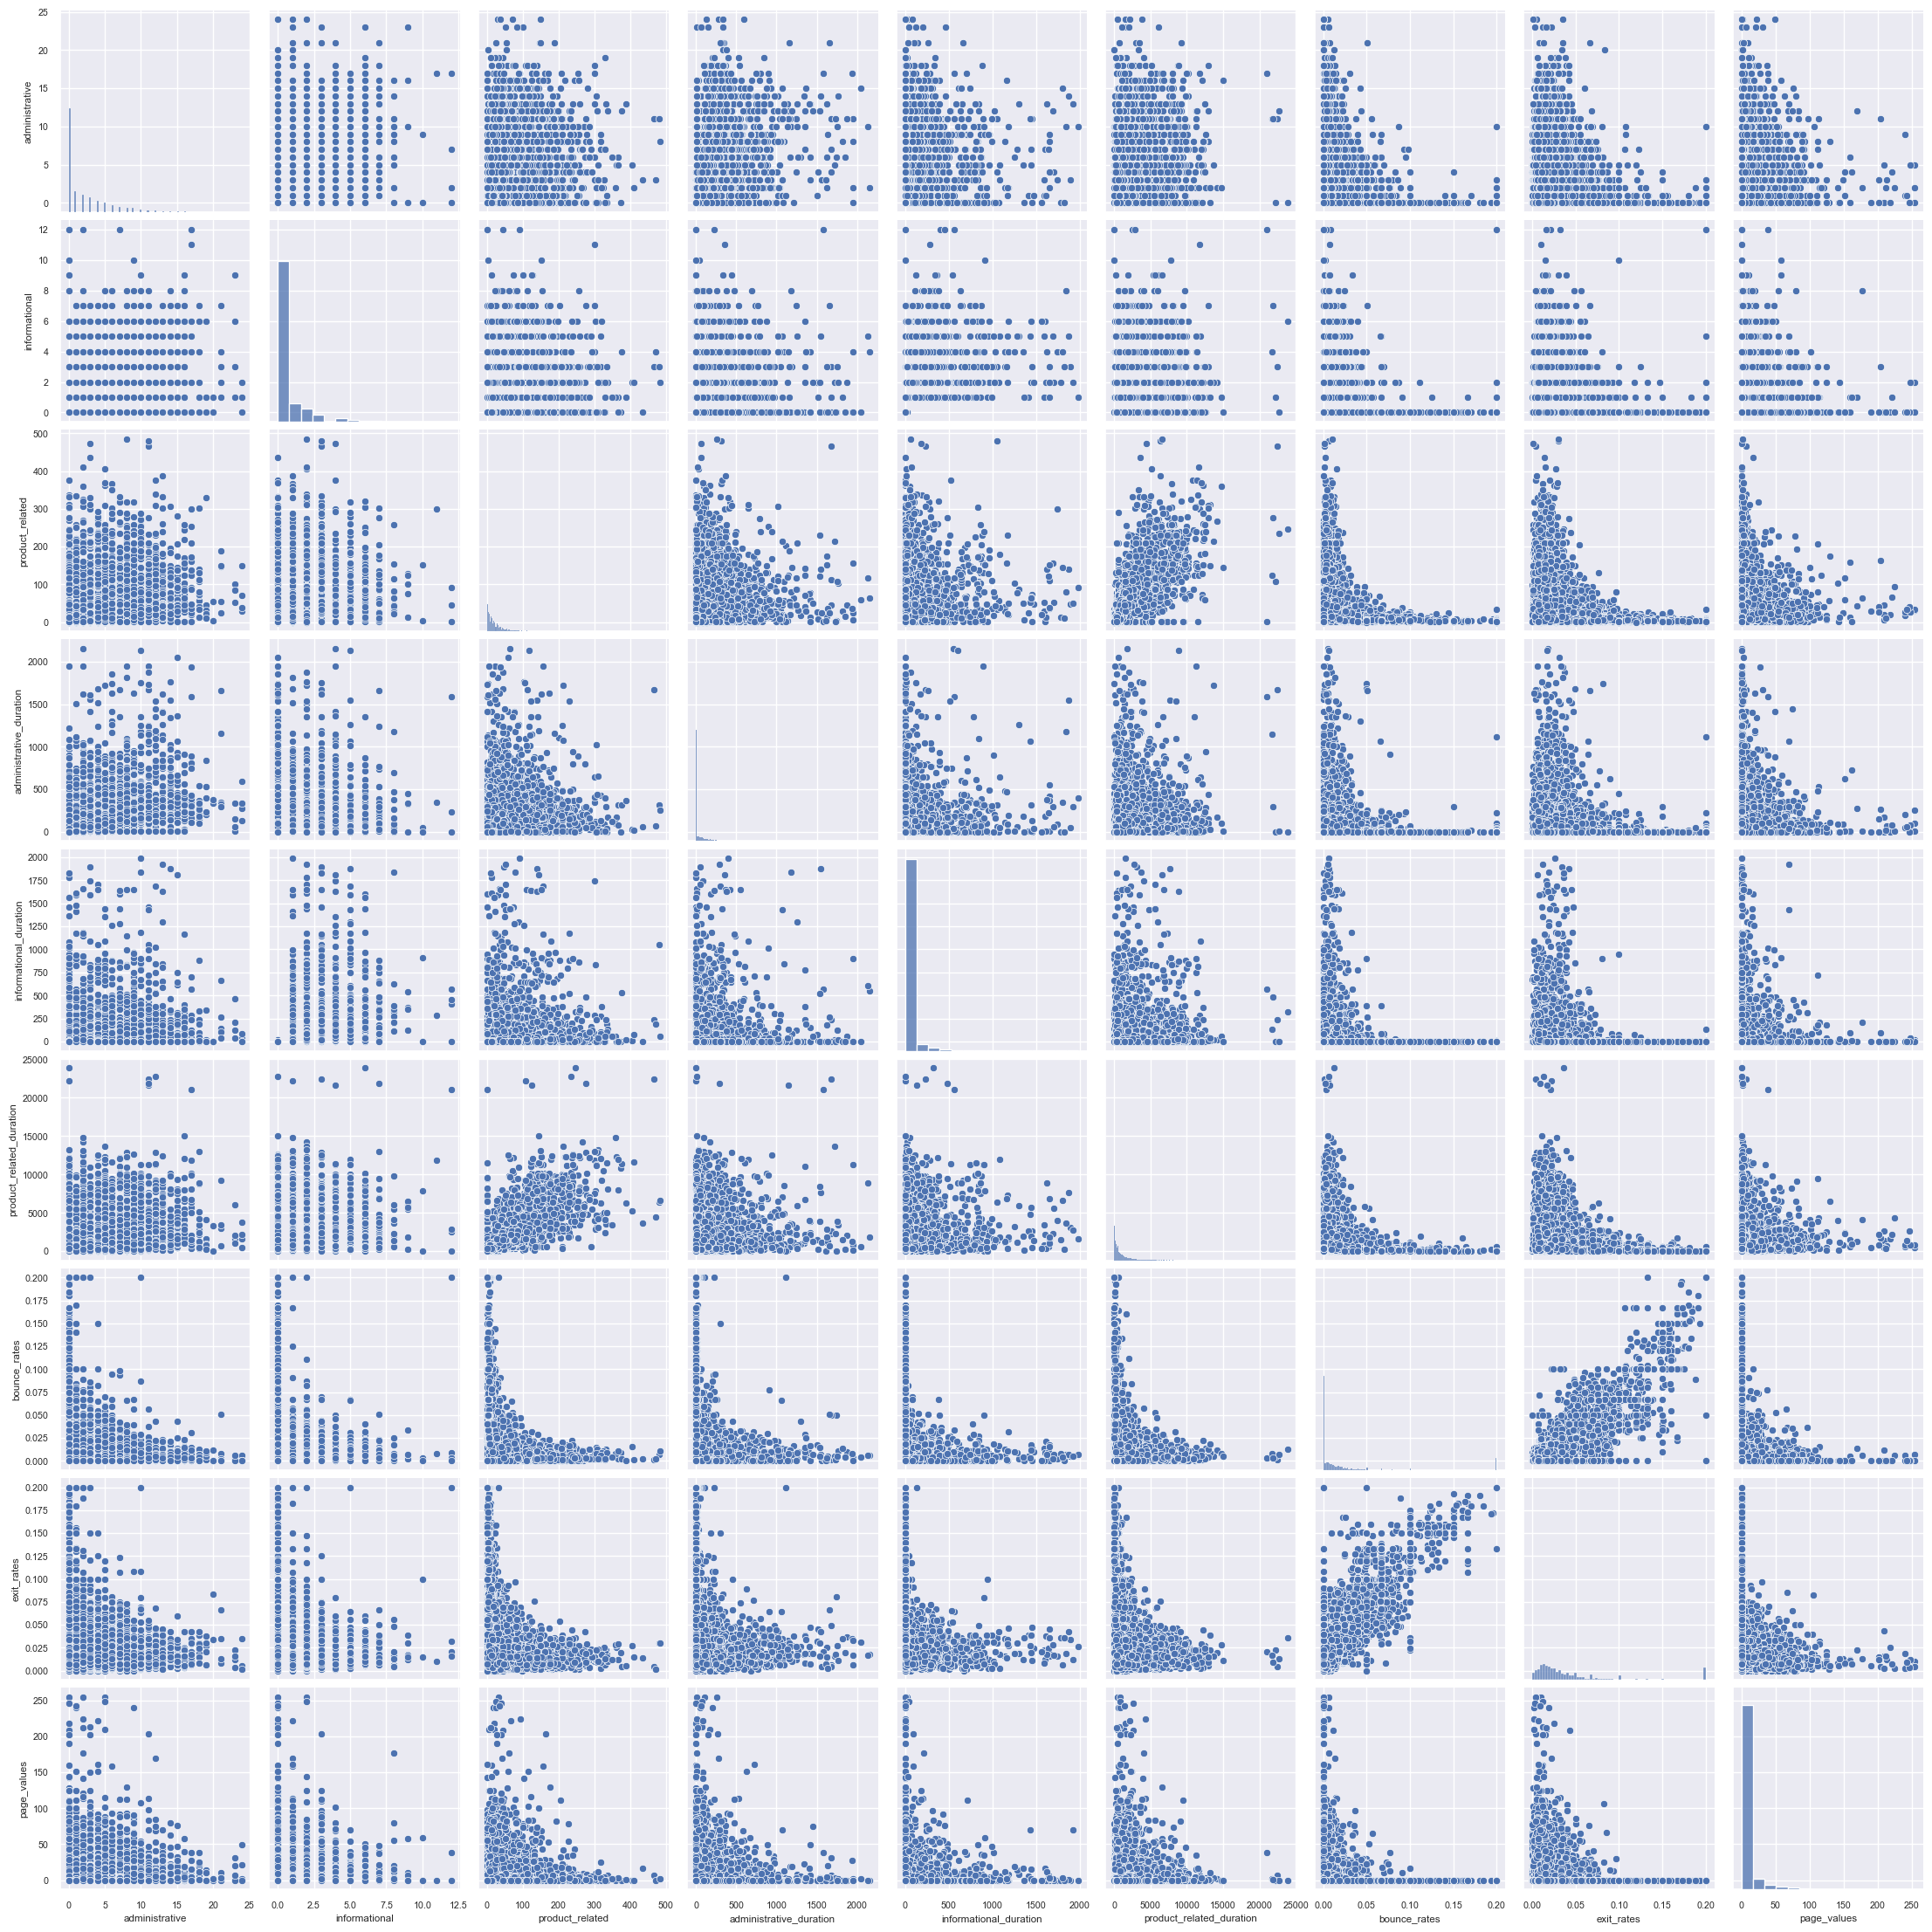

In [ ]:
numeric_cols = ['administrative',
                'informational',
                'product_related',
                'administrative_duration',
                'informational_duration',
                'product_related_duration',
                'bounce_rates',
                'exit_rates',
                'page_values',
                ]
plotter = Plotter(cleaned_df)
plotter.pair_correlations_grid(numeric_cols)

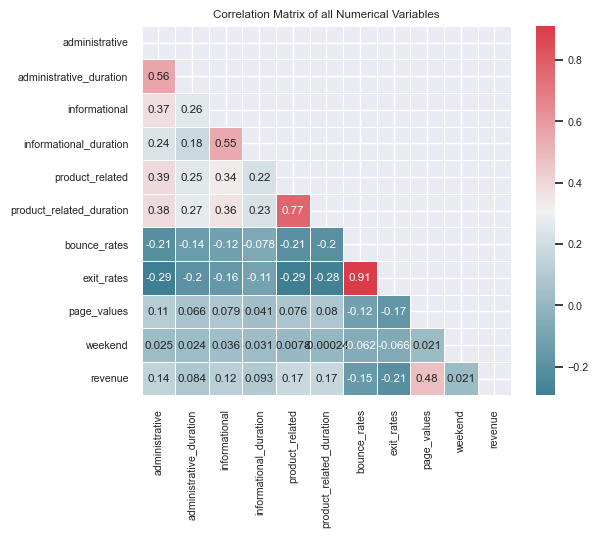

In [ ]:
plotter.correlation_matrix_df()

Bounce rates and exit rates are highly correlated.

To decide which column to drop between exit rates and bounce rate: need to compare the VIF (Variance inflation factor) of these columns against all remaining columns. Whichever column is contributing the most to the VIF factor can be dropped. 

In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
  
# the independent variables set 
X = cleaned_df[['administrative', 'administrative_duration', 'informational', 'informational_duration', 
                'product_related', 'product_related_duration', 'bounce_rates', 'exit_rates', 'page_values','weekend','revenue']] 
  
# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
# calculating VIF for each feature 
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
  
print(vif_data)

                     feature       VIF
0             administrative  2.362956
1    administrative_duration  1.761928
2              informational  1.936399
3     informational_duration  1.526346
4            product_related  3.690174
5   product_related_duration  3.674041
6               bounce_rates  5.609860
7                 exit_rates  6.022743
8                page_values  1.425008
9                    weekend  1.190258
10                   revenue  1.557914


In [66]:
column_to_drop = 'exit_rates'
ML_transformed_df.drop(column_to_drop, axis=1, inplace=True)
ML_transformed_df.columns

Index(['administrative', 'administrative_duration', 'informational',
       'informational_duration', 'product_related', 'product_related_duration',
       'bounce_rates', 'page_values', 'month', 'operating_systems', 'browser',
       'region', 'traffic_type', 'visitor_type', 'weekend', 'revenue'],
      dtype='object')

## **Further exploration: Categorical Distributions**

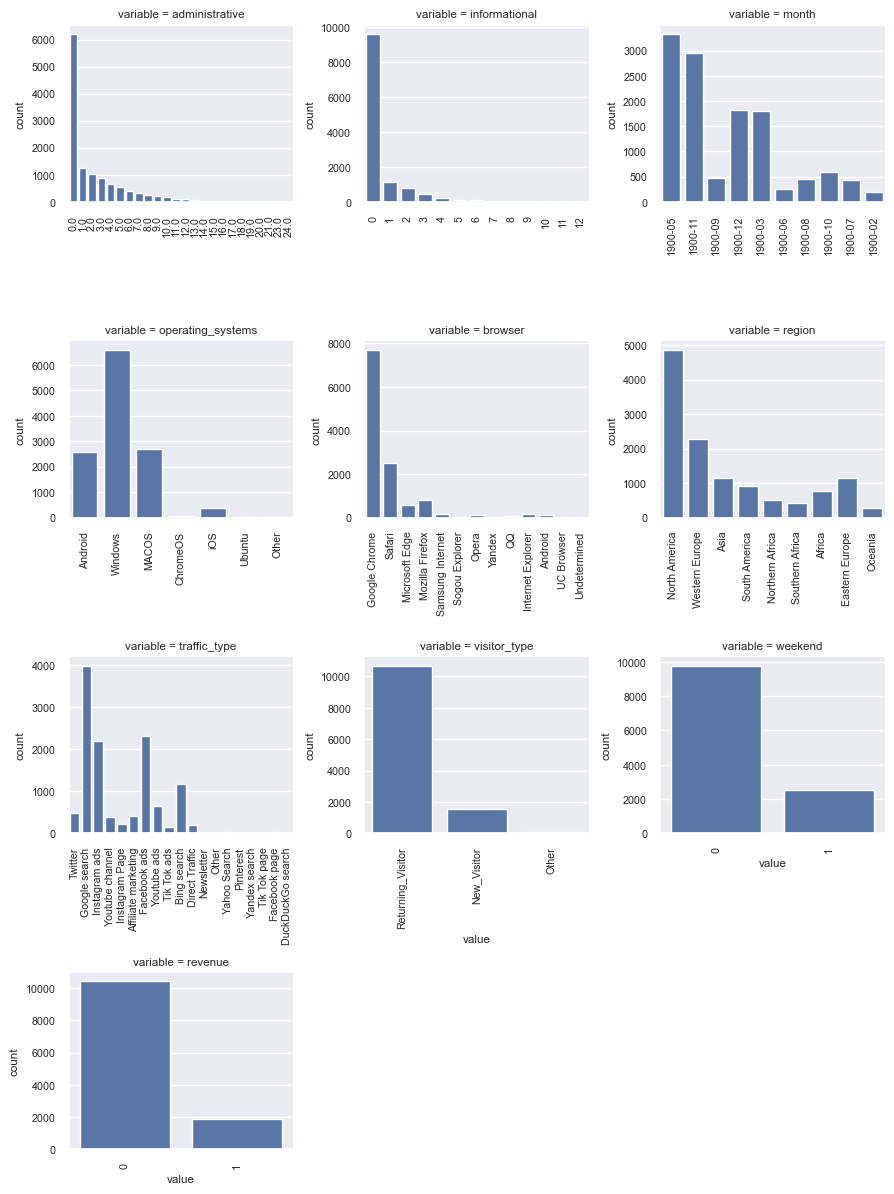

In [33]:
numeric_features_2 = ['administrative_duration',
                    'informational_duration',
                    'product_related_duration',
                    'bounce_rates',
                    'exit_rates',
                    'page_values',
                    'product_related'
                    ]
categorical_features = info_extractor.extract_categorical_features(numeric_features_2)
plotter.count_plots_grid(categorical_features)

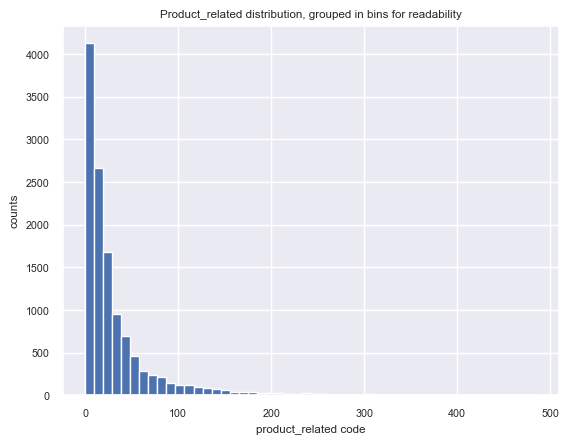

In [34]:
cleaned_df['product_related'].hist(bins = 50)
plt.title('Product_related distribution, grouped in bins for readability')
plt.xlabel('product_related code')
plt.ylabel('counts')
plt.show()

## **Data Cleaning: Detecting and Removing Outliers**

- CATEGORICAL VARIABLES: First, we can check for outliers in the categorical variables by inspecting the type of values and also by plotting their frequency distributions (see above). If a category is very infrequent, it could be considered an outlier. I have decided not to remove any values or categories here. I will take care of any necessary filtering and groupings in the analysis.

- NUMERICAL VARIABLES: I have done some quick check with IQR, but I decided to leave outlier checking during the analysis of the data.


In [ ]:
# Good analysis of the categorical columns
# NOTE Absolutely fine to leave removal of the outliers if you feel their values are true outliers. 
col = ['product_related_duration', 'exit_rates','page_values']
stats_test = StatisticalTests(cleaned_no_skew_df)
stats_tests.IQR_outliers(col)


Results for product_related_duration column:
Q1 (25th percentile): 195.0
Q3 (75th percentile): 1430.0
IQR: 1235.0
Outliers:
(1024, 17)

Results for exit_rates column:
Q1 (25th percentile): 0.014
Q3 (75th percentile): 0.049
IQR: 0.035
Outliers:
(1080, 17)

Results for page_values column:
Q1 (25th percentile): 0.0
Q3 (75th percentile): 0.0
IQR: 0.0
Outliers:
(2763, 17)


## Download processed dataset to local folder as .csv

In [ ]:
#preprocessed_data = cleaned_no_skew_df.copy()
#preprocessed_data.to_csv("preprocessed_data.csv")
#preprocessed_data_skewed = cleaned_df.copy()
#preprocessed_data_skewed.to_csv("preprocessed_skewed_data.csv")